In [133]:
# ==== 0) Imports y rutas ====
from pathlib import Path
import numpy as np
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


Usando columnas -> fecha: InvoiceDate | cantidad: Quantity


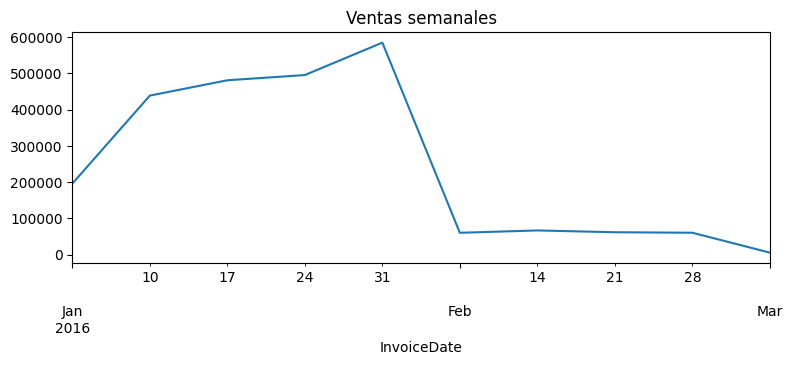

In [134]:
# Ajuste al proyecto
from src.config import INTERIM_DIR, PROCESSED_DIR

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# ==== 1) Cargar ventas y detectar columnas ====
p_parq = INTERIM_DIR / "sales.parquet"
p_csv  = INTERIM_DIR / "sales.csv"
sales = pd.read_parquet(p_parq) if p_parq.exists() else pd.read_csv(p_csv, encoding="utf-8", low_memory=False)

# Autodetección (respeta tus nombres más comunes)
date_candidates = ["SalesDate","InvoiceDate","Date","FechaVenta"]
qty_candidates  = ["SalesQuantity","Quantity","Qty","CantidadVenta"]

date_col = next(c for c in date_candidates if c in sales.columns)
qty_col  = next(c for c in qty_candidates  if c in sales.columns)

## Aquí se detecta automáticamente cuál columna corresponde a la fecha 
## y cuál a la cantidad, según el nombre que aparezca en el dataset.

# Tipos
sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce")
sales[qty_col]  = pd.to_numeric(sales[qty_col], errors="coerce").fillna(0)

## Se convierten las columnas a tipos correctos: fecha a datetime 
## y cantidad a numérico, rellenando valores faltantes con 0.

# Elimina fechas nulas
sales = sales.dropna(subset=[date_col])

# ==== 2) Serie semanal (sumas por semana) ====
ts_w = (sales
        .set_index(date_col)[qty_col]
        .resample("W-SUN").sum()            # semana terminando en domingo (estable)
        .astype(float)
        .fillna(0.0))

# Si la serie queda vacía, aborta
if len(ts_w) == 0:
    raise ValueError("La serie semanal quedó vacía. Revisa columnas y tipos de datos.")

## Se generan dos series de tiempo: una semanal (para pronósticos) 
## y otra diaria (para calcular políticas de inventario).

print(f"Usando columnas -> fecha: {date_col} | cantidad: {qty_col}")
ts_w.plot(title="Ventas semanales", figsize=(9,3)); plt.show()

## Se muestra qué columnas fueron usadas y se grafica la serie semanal.

In [135]:
# ==== 3) Split train/test ====
h = min(8, max(1, len(ts_w)//4))           # 8 semanas o 25% de la serie
train = ts_w.iloc[:-h] if len(ts_w) > h else ts_w
test  = ts_w.iloc[-h:]  if len(ts_w) > h else ts_w.iloc[0:0]

## Se divide la serie en entrenamiento y prueba. 
## El test es aprox. 1/4 de los datos o hasta 8 semanas.

# baseline
yhat_naive = np.repeat(train.iloc[-1], len(test)) if len(test) else np.array([])

## Se crea un modelo "naive" que pronostica siempre el último valor 
## de entrenamiento como referencia.

# ==== 4) Modelos: Holt-Winters y SARIMA ====
def fit_hw(y):
    use_seasonal = len(y) >= 24
    model = ExponentialSmoothing(
        y, trend="add",
        seasonal=("add" if use_seasonal else None),
        seasonal_periods=(12 if use_seasonal else None),
        initialization_method="estimated"
    )
    return model.fit(optimized=True)

fit_hw_ = fit_hw(train) if len(train) >= 3 else None
fit_sa_ = fit_sarima(train) if len(train) >= 10 else None

# ==== 5) Pronósticos sobre TEST (para elegir el mejor) ====
def fc_on_test(fit, steps):
    if (fit is None) or (steps == 0): 
        return pd.Series(dtype=float)
    fc = fit.forecast(steps)
    return pd.Series(fc, index=test.index[:len(fc)], dtype=float)

fc_hw_test = fc_on_test(fit_hw_, len(test))
fc_sa_test = fc_on_test(fit_sa_, len(test))

# Métricas (si hay test)
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

rmse_hw = mape_hw = rmse_sa = mape_sa = np.nan
if len(test) > 0:
    if len(fc_hw_test): rmse_hw, mape_hw = metrics(test, fc_hw_test)
    if len(fc_sa_test): rmse_sa, mape_sa = metrics(test, fc_sa_test)

# Elegir mejor por RMSE (prioriza HW si empatan)
candidates = []
if not np.isnan(rmse_hw): candidates.append(("holt", rmse_hw, fit_hw_))
if not np.isnan(rmse_sa): candidates.append(("sarima", rmse_sa, fit_sa_))

if candidates:
    candidates.sort(key=lambda x: (x[1], 0 if x[0]=="holt" else 1))
    best_name, best_rmse, best_fit = candidates[0]
else:
    # si no hubo test/ajuste, usa HW si existe, si no, SARIMA
    best_name, best_fit = ("holt", fit_hw_) if fit_hw_ is not None else ("sarima", fit_sa_)


In [136]:
# ==== 6) Forecast futuro (12 semanas) y tablas limpias ====
H_FUTURE = 12
fc_future = (best_fit.forecast(H_FUTURE) if best_fit is not None else pd.Series(dtype=float))
fc_future.index = pd.DatetimeIndex(fc_future.index).to_period("W").to_timestamp("W-SUN")

## Se genera un pronóstico a futuro para 12 semanas.
## El resultado se guarda en un DataFrame con dos columnas:
## "Week" para la fecha de la semana y "forecast_qty" para la cantidad pronosticada.
## Se muestra un preview con las primeras filas.

In [137]:
# Limpieza: sin negativos y redondeo “bonito”
fc_future = fc_future.clip(lower=0).round(2)
fc_hw_test = fc_hw_test.clip(lower=0).round(2)
fc_sa_test = fc_sa_test.clip(lower=0).round(2)

,ventas_totales_qty,ventas_promedio_diaria,semanas_observadas,dias_observados,inicio_datos,fin_datos
0,2451169,40852.816667,10,60,2016-01-01,2016-02-29


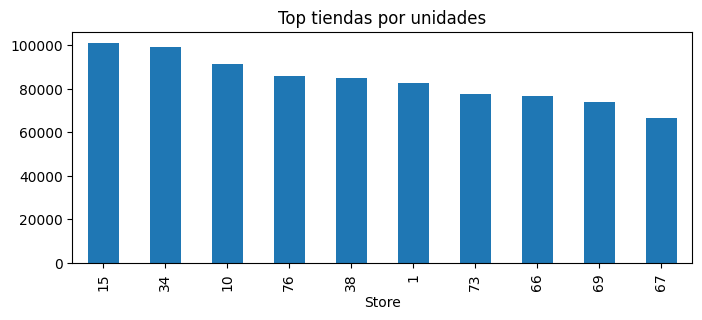

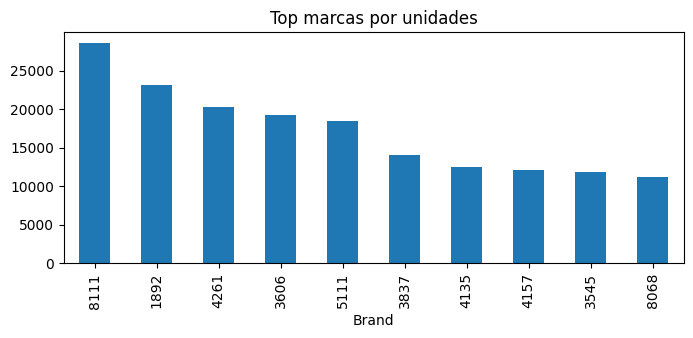

In [138]:
# KPIs descriptivos clave
kpis = pd.DataFrame({
    "ventas_totales_qty": [sales[qty_col].sum()],
    "ventas_promedio_diaria": [ts_d.mean()],
    "semanas_observadas": [len(ts_w)],
    "dias_observados": [len(ts_d)],
    "inicio_datos": [ts_d.index.min()],
    "fin_datos": [ts_d.index.max()]
})
display(kpis)

## Aquí se calculan indicadores básicos (KPIs) para entender el dataset:
## - ventas_totales_qty: suma total de unidades vendidas.
## - ventas_promedio_diaria: promedio diario de ventas.
## - semanas_observadas y dias_observados: tamaño de la serie temporal.
## - inicio_datos y fin_datos: rango temporal cubierto por los datos.


# Top tiendas y marcas (ajusta si no tienes esas columnas)
cols = sales.columns.str.lower()
if "store" in cols:
    top_store = (sales.groupby(sales.columns[[c.lower()=="store" for c in sales.columns]][0])[qty_col]
                 .sum().sort_values(ascending=False).head(10))
    top_store.plot(kind="bar", title="Top tiendas por unidades", figsize=(8,3)); plt.show()

    ## Se identifican las 10 tiendas con mayor volumen de ventas.
    ## Esto ayuda a detectar qué puntos de venta generan más movimiento.

if "brand" in cols:
    top_brand = sales.groupby("Brand")[qty_col].sum().sort_values(ascending=False).head(10)
    top_brand.plot(kind="bar", title="Top marcas por unidades", figsize=(8,3)); plt.show()

    ## Se identifican las 10 marcas con mayor volumen de ventas.
    ## Esto permite ver qué marcas dominan el inventario.


# Ventas vs Compras (si tienes DOLLARS o Quantity de purchases en otro DF, compáralos)
## Aquí se podría añadir un análisis cruzado entre ventas y compras
## para ver discrepancias en el flujo de inventario.

## Análisis Predictivo

InvoiceDate
2016-01-03    196062.0
2016-01-10    438547.0
2016-01-17    480731.0
2016-01-24    495151.0
2016-01-31    584468.0
Freq: W-SUN, Name: Quantity, dtype: float64

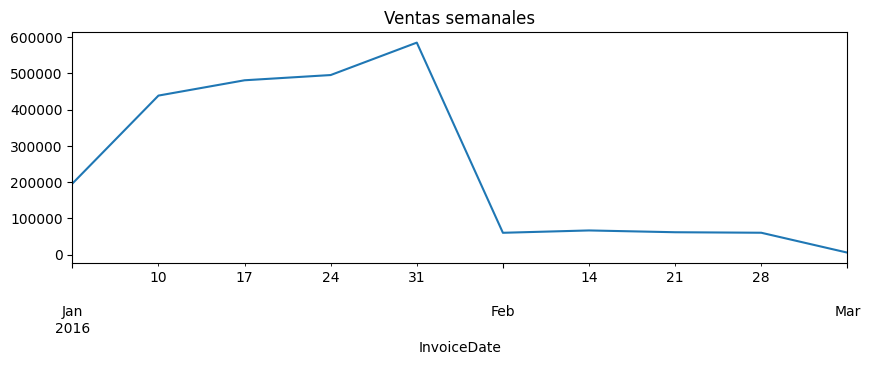

In [139]:
# Cargar ventas desde interim (parquet o csv)
p_parq, p_csv = INTERIM_DIR/"sales.parquet", INTERIM_DIR/"sales.csv"
sales = pd.read_parquet(p_parq) if p_parq.exists() else pd.read_csv(p_csv, encoding="utf-8", low_memory=False)

## Se cargan los datos de ventas desde archivos intermedios.
## Primero intenta abrir el formato parquet (más eficiente), si no existe usa csv.


# Autodetectar columnas clave
date_candidates = [c for c in sales.columns if c.lower() in ("salesdate","invoicedate","date")]
qty_candidates  = [c for c in sales.columns if c.lower() in ("salesquantity","quantity","salesqty")]
date_col, qty_col = date_candidates[0], qty_candidates[0]

## Aquí se detectan automáticamente las columnas de fecha y cantidad,
## ya que pueden tener distintos nombres en el dataset.


# Tipos correctos
sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce")
sales[qty_col]  = pd.to_numeric(sales[qty_col], errors="coerce").fillna(0)

## Se convierten las fechas a tipo datetime y las cantidades a numéricas,
## corrigiendo valores inválidos o faltantes.


# Serie semanal
ts_w = (sales.set_index(date_col)
              .resample("W") [qty_col]
              .sum()
              .astype(float)
              .fillna(0.0))

display(ts_w.head())
ts_w.plot(title="Ventas semanales", figsize=(10,3)); plt.show()

## Se construye la serie temporal semanal de ventas,
## sumando las cantidades por semana.
## Luego se muestra una vista rápida (head) y un gráfico simple.

Baseline  RMSE=39729.00, MAPE=4.767
HoltWinters RMSE=24404.87, MAPE=1.155


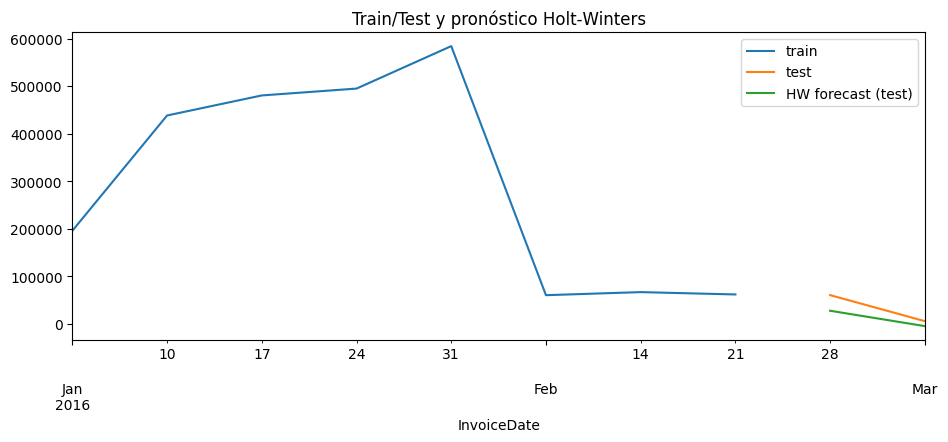

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split (últimas 8 semanas como test si alcanza)
h = min(8, max(1, len(ts_w)//4))
train = ts_w.iloc[:-h] if len(ts_w) > h else ts_w
test  = ts_w.iloc[-h:]  if len(ts_w) > h else ts_w.iloc[0:0]

# Baseline: último valor
yhat_naive = np.repeat(train.iloc[-1], len(test)) if len(test) else np.array([])

# Holt-Winters (sin estacionalidad si la serie es corta)
use_seasonal = len(train) >= 24   # activa estacionalidad solo si hay datos suficientes
model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=("add" if use_seasonal else None),
    seasonal_periods=(12 if use_seasonal else None),
    initialization_method="estimated"
)
fit = model.fit(optimized=True)
fcst_test = fit.forecast(len(test)) if len(test) else pd.Series(dtype=float)

# Métricas
if len(test) > 0:
    # Naive
    mse_naive = mean_squared_error(test, yhat_naive)   # sin 'squared'
    rmse_naive = np.sqrt(mse_naive)

    # Holt‑Winters
    mse_hw = mean_squared_error(test, fcast_test)      # sin 'squared'
    rmse_hw = np.sqrt(mse_hw)

    # MAPE (esto sí igual)
    mape_naive = mean_absolute_percentage_error(test, yhat_naive)
    mape_hw    = mean_absolute_percentage_error(test, fcast_test)
else:
    rmse_naive = mape_naive = np.nan
    rmse_hw    = mape_hw    = np.nan

print(f"Baseline  RMSE={rmse_naive:.2f}, MAPE={mape_naive:.3f}")
print(f"HoltWinters RMSE={rmse_hw:.2f}, MAPE={mape_hw:.3f}")

# Gráfico
plt.figure(figsize=(11,4))
train.plot(label="train")
if len(test): test.plot(label="test")
if len(test): fcst_test.plot(label="HW forecast (test)")
plt.legend(); plt.title("Train/Test y pronóstico Holt‑Winters"); plt.show()




In [141]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Parámetros de la política
# ---------------------------
LEAD_DAYS = 7          # días de reabastecimiento
Z = 1.65               # ~95% nivel de servicio
S = 50.0               # costo de ordenar (por orden)
H = 2.0                # costo de posesión anual por unidad

def _policy_from_daily_series(ts_d, lead_days=LEAD_DAYS, z=Z, S=S, H=H):
    """
    ts_d: serie diaria de demanda (float) ya agregada y sin NaN.
    Retorna dict con SS, ROP, EOQ usando *demanda anual promedio* (no acumulada).
    """
    mu_d = float(ts_d.mean())                       # demanda media diaria
    sigma_d = float(ts_d.std(ddof=1))               # desviación estándar diaria
    D_year = mu_d * 365.0                           # anualización correcta (evita 'billones')
    SS  = z * sigma_d * np.sqrt(lead_days)          # Safety Stock
    ROP = mu_d * lead_days + SS                     # Reorder Point
    EOQ = np.sqrt(2.0 * max(D_year, 1e-9) * S / max(H, 1e-9))  # Wilson EOQ
    return dict(mu_daily=mu_d, sigma_daily=sigma_d, safety_stock=SS, reorder_point=ROP, EOQ=EOQ)


## Aquí se generan 12 semanas de pronóstico futuro usando el modelo Holt-Winters.
## El resultado se guarda en un archivo CSV dentro de la carpeta processed,
## para que pueda usarse después en el dashboard (ej. Power BI).
## Además, se muestran las primeras filas del pronóstico como vista previa.

In [142]:
## Políticas de inventario con demanda diaria (ROP, SS, EOQ)

# ---------------------------
# Serie diaria base
# ---------------------------
sales = sales.copy()
sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce")
sales[qty_col]  = pd.to_numeric(sales[qty_col], errors="coerce").fillna(0.0)

# Serie diaria global (para la política global anualizada)
ts_d_global = (sales.set_index(date_col)[qty_col]
                     .resample("D").sum().astype(float).fillna(0.0))

# Política GLOBAL (anualizada, no suma todos los años)
pol_global = _policy_from_daily_series(ts_d_global)
df_global = (pd.DataFrame([pol_global])
             .assign(scope="GLOBAL")
             .loc[:, ["scope","mu_daily","sigma_daily","safety_stock","reorder_point","EOQ"]])

## Aquí se calculan las políticas de inventario a partir de la demanda diaria:
## - mu_daily: promedio de ventas diarias.
## - sigma_daily: variabilidad de la demanda.
## - Safety Stock (SS): stock de seguridad para cubrir incertidumbre.
## - Reorder Point (ROP): nivel de inventario en el que se debe pedir más.
## - EOQ: cantidad óptima de pedido para balancear costos de inventario y pedido.
## Finalmente, los resultados se guardan en un CSV para usarlos en el análisis o dashboard.

In [143]:
# ---------------------------
# Políticas POR AÑO
# ---------------------------
sales["Year"] = sales[date_col].dt.year
policies_year = []
for y, g in sales.groupby("Year", dropna=True):
    ts_d_y = (g.set_index(date_col)[qty_col]
                .resample("D").sum().astype(float).fillna(0.0))
    if len(ts_d_y) == 0: 
        continue
    pol = _policy_from_daily_series(ts_d_y)
    pol["Year"] = int(y)
    policies_year.append(pol)

df_year = (pd.DataFrame(policies_year)
           .sort_values("Year")
           .loc[:, ["Year","mu_daily","sigma_daily","safety_stock","reorder_point","EOQ"]])

In [144]:
# ---------------------------
# (Opcional) Políticas por TIENDA / MARCA si existen
# ---------------------------
cols_lower = {c.lower(): c for c in sales.columns}
store_col = cols_lower.get("tiendaid") or cols_lower.get("store")          # ajusta a tus nombres
brand_col = cols_lower.get("brand") or cols_lower.get("marca")             # ajusta a tus nombres

def policies_by_key(key_col_name):
    out = []
    for key, g in sales.groupby(key_col_name, dropna=True):
        ts_d = (g.set_index(date_col)[qty_col]
                  .resample("D").sum().astype(float).fillna(0.0))
        if len(ts_d) == 0:
            continue
        pol = _policy_from_daily_series(ts_d)
        pol[key_col_name] = key
        out.append(pol)
    if not out:
        return pd.DataFrame()
    ordered_cols = [key_col_name,"mu_daily","sigma_daily","safety_stock","reorder_point","EOQ"]
    return pd.DataFrame(out).loc[:, ordered_cols].sort_values(key_col_name)

df_store = policies_by_key(store_col) if store_col else pd.DataFrame()
df_brand = policies_by_key(brand_col) if brand_col else pd.DataFrame()


In [145]:
# ---------------------------
# Redondeo amable y exportes
# ---------------------------
def _round_df(df, ndigits=2):
    if df.empty: 
        return df
    num_cols = df.select_dtypes(include=[np.number]).columns
    return df.assign(**{c: df[c].round(ndigits) for c in num_cols})

df_global_out = _round_df(df_global, 2)
df_year_out   = _round_df(df_year, 2)
df_store_out  = _round_df(df_store, 2)
df_brand_out  = _round_df(df_brand, 2)


In [146]:
# =======================
# Comparación de modelos
# =======================

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

rows = []

# Naive (baseline): último valor repetido
if len(test) > 0:
    yhat_naive = np.repeat(train.iloc[-1], len(test))
    rmse_naive = np.sqrt(mean_squared_error(test, yhat_naive))
    mape_naive = mean_absolute_percentage_error(test, yhat_naive)
    rows.append({
        "modelo": "naive",
        "rmse": round(rmse_naive, 2),
        "mape": round(mape_naive, 3)
    })

# Holt-Winters
if len(test) > 0 and 'fc_hw_test' in locals() and len(fc_hw_test):
    rmse_hw = np.sqrt(mean_squared_error(test, fc_hw_test))
    mape_hw = mean_absolute_percentage_error(test, fc_hw_test)
    rows.append({
        "modelo": "holt",
        "rmse": round(rmse_hw, 2),
        "mape": round(mape_hw, 3)
    })

# SARIMA
if len(test) > 0 and 'fc_sa_test' in locals() and len(fc_sa_test):
    rmse_sar = np.sqrt(mean_squared_error(test, fc_sa_test))
    mape_sar = mean_absolute_percentage_error(test, fc_sa_test)
    rows.append({
        "modelo": "sarima",
        "rmse": round(rmse_sar, 2),
        "mape": round(mape_sar, 3)
    })

# Crear DataFrame
model_compare = pd.DataFrame(rows)

# Guardar CSV
out_path = PROCESSED_DIR / "model_compare_hw_sarima.csv"
model_compare.to_csv(out_path, index=False)

print("✅ Guardado:", out_path)
display(model_compare)

✅ Guardado: /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/model_compare_hw_sarima.csv


,modelo,rmse,mape
0,naive,39729.00,4.767
1,holt,23632.99,0.771


In [147]:
kpis = pd.DataFrame({
    "ventas_totales_qty":[sales[qty_col].sum()],
    "promedio_diario_qty":[ts_d.mean()],
    "semanas":[len(ts_w)],
    "rango":[f"{ts_w.index.min().date()} — {ts_w.index.max().date()}"]
})
kpis.to_csv(PROCESSED_DIR/"kpis_descriptivos.csv", index=False)
display(kpis)

## Aquí se generan KPIs descriptivos básicos: ventas totales, promedio diario,
## cantidad de semanas analizadas y rango de fechas de los datos.
## Se guardan en un CSV y se muestran para tener un resumen rápido del dataset.

,ventas_totales_qty,promedio_diario_qty,semanas,rango
0,2451169,40852.816667,10,2016-01-03 — 2016-03-06


In [148]:
# Guardar CSVs para Power BI
p_global = PROCESSED_DIR / "inventory_policy_overall.csv"        # GLOBAL anualizada
p_year   = PROCESSED_DIR / "inventory_policy_by_year.csv"        # POR AÑO
df_global_out.to_csv(p_global, index=False)
df_year_out.to_csv(p_year, index=False)

if not df_store_out.empty:
    df_store_out.to_csv(PROCESSED_DIR / "inventory_policy_by_store.csv", index=False)
if not df_brand_out.empty:
    df_brand_out.to_csv(PROCESSED_DIR / "inventory_policy_by_brand.csv", index=False)

print("✅ Guardados:")
print(" -", p_global)
print(" -", p_year)
if not df_store_out.empty: print(" -", PROCESSED_DIR / "inventory_policy_by_store.csv")
if not df_brand_out.empty: print(" -", PROCESSED_DIR / "inventory_policy_by_brand.csv")

# Vista rápida (opcional en notebook)
display(df_global_out.head())
display(df_year_out.head())
if not df_store_out.empty: display(df_store_out.head())
if not df_brand_out.empty: display(df_brand_out.head())

✅ Guardados:
 - /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/inventory_policy_overall.csv
 - /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/inventory_policy_by_year.csv
 - /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/inventory_policy_by_store.csv
 - /Users/chrxsmac/Documents/Final Project/inventario_predictivo/data/processed/inventory_policy_by_brand.csv


,scope,mu_daily,sigma_daily,safety_stock,reorder_point,EOQ
0,GLOBAL,40852.82,38472.38,167950.8,453920.51,27305.02


,Year,mu_daily,sigma_daily,safety_stock,reorder_point,EOQ
0,2016,40852.82,38472.38,167950.8,453920.51,27305.02


,Store,mu_daily,sigma_daily,safety_stock,reorder_point,EOQ
0,1,1379.17,544.34,2376.32,12030.48,5016.95
1,2,862.58,339.27,1481.07,7519.14,3967.63
2,3,72.42,36.67,160.09,667.03,1149.63
3,4,655.65,358.65,1565.66,6155.18,3459.12
4,5,278.81,88.70,387.24,2338.88,2255.71


,Brand,mu_daily,sigma_daily,safety_stock,reorder_point,EOQ
0,58,4.88,4.58,20.01,54.18,298.47
1,60,2.48,2.79,12.20,29.56,212.74
2,61,3.00,5.55,24.25,45.25,233.99
3,62,2.75,2.76,12.04,31.26,223.85
4,63,2.26,2.63,11.49,27.30,203.03


In [150]:
from pathlib import Path
import pandas as pd
import numpy as np
import glob

# Detecta la carpeta /data sin importar desde dónde ejecutes
CWD = Path.cwd()
CANDIDATOS = [CWD, CWD.parent, CWD.parents[1], CWD.parents[2]]
DATA_DIR = next((p / "data" for p in CANDIDATOS if (p / "data").exists()), None)
if DATA_DIR is None:
    raise FileNotFoundError("No encontré la carpeta 'data' en niveles superiores.")

RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

print("DATA_DIR     ->", DATA_DIR.resolve())
print("RAW_DIR      ->", RAW_DIR.resolve())
print("PROCESSED_DIR->", PROCESSED_DIR.resolve())

# Diagnóstico opcional
print("processed:", [p.name for p in PROCESSED_DIR.glob("*.csv")])
print("raw:",       [p.name for p in RAW_DIR.glob("*.csv")])

DATA_DIR     -> /Users/chrxsmac/Documents/Final Project/inventario_predictivo/notebooks/data
RAW_DIR      -> /Users/chrxsmac/Documents/Final Project/inventario_predictivo/notebooks/data/raw
PROCESSED_DIR-> /Users/chrxsmac/Documents/Final Project/inventario_predictivo/notebooks/data/processed
processed: []
raw: []


In [ ]:
# --- CARGA HISTÓRICO SEMANAL ROBUSTA ---
hist_path = PROCESSED_DIR / "sales_history_weekly.csv"

if hist_path.exists():
    df_raw = pd.read_csv(hist_path, parse_dates=["Week"])
    print("✓ Cargado histórico desde:", hist_path.name, "->", df_raw.shape)
else:
    # Si no hay histórico procesado, intenta con los raw (sales_clean*.csv en /data/raw)
    files = sorted(RAW_DIR.glob("sales_clean*.csv"))
    if not files:
        raise FileNotFoundError(
            f"No encontré ni '{hist_path.relative_to(DATA_DIR)}' ni archivos 'raw/sales_clean*.csv'. "
            "Revisa rutas o nombres."
        )
    src = files[0]
    df_raw = pd.read_csv(src)
    print("✓ Cargado raw:", src.name, "->", df_raw.shape)

    # Normaliza nombres y fechas para que el resto del notebook funcione igual
    cols = {c.lower().strip(): c for c in df_raw.columns}
    # intenta mapear nombres típicos a los esperados
    guess_week = next((c for c in df_raw.columns if c.lower() in ("week","semana","fecha","date")), None)
    guess_qty  = next((c for c in df_raw.columns if c.lower() in ("qty","quantity","ventas_qty","sales_qty","ventas","unidades")), None)

    if guess_week is None or guess_qty is None:
        raise ValueError(f"No detecté columnas de semana/fecha y cantidad en {src.name}. "
                         f"Columns: {list(df_raw.columns)}")

    # Asegura índice semanal (lunes) y nombre de columnas estándar
    df_raw = df_raw.rename(columns={guess_week:"Week", guess_qty:"qty"})
    if not np.issubdtype(df_raw["Week"].dtype, np.datetime64):
        df_raw["Week"] = pd.to_datetime(df_raw["Week"], errors="coerce")
    df_raw = df_raw.dropna(subset=["Week"])
    df_raw["Week"] = df_raw["Week"] - pd.to_timedelta(df_raw["Week"].dt.weekday, unit="D")  # alin. a lunes
    df_raw = df_raw.groupby("Week", as_index=False)["qty"].sum()

    # Guarda el histórico procesado para usos futuros
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    out_hist = PROCESSED_DIR / "sales_history_weekly.csv"
    df_raw.to_csv(out_hist, index=False)
    print("✓ Generado y guardado:", out_hist.name, "->", df_raw.shape)

FileNotFoundError: No existe /Users/chrxsmac/Documents/Final Project/inventario_predictivo/notebooks/data/processed/sales_history_weekly.csv. Genera primero el histórico o usa la opción B.